<a href="https://colab.research.google.com/github/alexrafkin/ideal-parakeet/blob/main/FeatureEngineeringII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

ed = pd.read_sql_query('select * from useducation',con=engine)
engine.dispose()

ed2=ed.copy()

Don't forget to apply the most suitable missing-value-filling techniques you applied in the previous checkpoints to the data. You can provide your answers to the following questions after you have handled the missing values.

In [ ]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = ed["STATE"].unique()

for state in states:
    ed.loc[ed["STATE"] == state, fill_list] = ed.loc[ed["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
ed.dropna(inplace=True)

Say you want to understand the relationship between government expenditures and the students' overall success in math and reading.

1. Compute the average score for each row for all students weighted properly by grade. In other words, each row will have its own average. Notice that the number of students in the fourth grade isn't the same as the number of students in the eighth grade. So, you should appropriately weigh the scores.


In [ ]:
ed['avg_score'] = (ed['AVG_MATH_4_SCORE']*ed['GRADES_4_G']+ed['AVG_READING_4_SCORE']*ed['GRADES_4_G']+ed['AVG_MATH_8_SCORE']*ed['GRADES_8_G']+ed['AVG_READING_8_SCORE']*ed['GRADES_8_G'])/(2*ed['GRADES_4_G']+2*ed['GRADES_8_G'])

In [ ]:
ed.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_score
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,935115.0,322883.0,286699.0,9633.0,60949.0,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,235.106342
211,1996_ARIZONA,ARIZONA,1996,764681.0,4143304.0,378917.0,1798363.0,1966024.0,4391555.0,1860007.0,1193260.0,220650.0,877190.0,4495.0,64613.0,62793.0,60514.0,42041.0,511925.0,210289.0,726709.0,217.575940,267.874834,206.529788,263.283638,238.321404
212,1996_ARKANSAS,ARKANSAS,1996,452907.0,2183384.0,192152.0,1296247.0,694985.0,2297381.0,1264275.0,636106.0,127007.0,203555.0,1980.0,36442.0,33855.0,37064.0,27613.0,283883.0,131997.0,417860.0,215.846436,261.652745,208.837716,271.834590,240.773675
213,1996_CALIFORNIA,CALIFORNIA,1996,5460484.0,31282981.0,2603882.0,17061474.0,11617625.0,31561692.0,16880730.0,9222569.0,2362407.0,2580639.0,73233.0,469965.0,435217.0,406456.0,298669.0,3516572.0,1525618.0,5115423.0,209.129083,262.772478,201.912591,269.197451,234.719834
214,1996_COLORADO,COLORADO,1996,655679.0,3891203.0,194998.0,1664676.0,2031529.0,4075165.0,2052264.0,1127563.0,143767.0,588209.0,12520.0,50707.0,52524.0,52269.0,37179.0,423510.0,185700.0,621730.0,225.805858,275.608214,221.653243,268.168154,247.750273


2. What are the correlations between this newly created score variable and the expenditure types? Which one of the expenditure types is more correlated than the others?


In [ ]:
ed[["avg_score","TOTAL_EXPENDITURE","INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

,avg_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
avg_score,1.000000,0.074155,0.087386,0.079002,0.010959,-0.005389
TOTAL_EXPENDITURE,0.074155,1.000000,0.990255,0.992988,0.943702,0.925784
INSTRUCTION_EXPENDITURE,0.087386,0.990255,1.000000,0.974399,0.902173,0.884798
SUPPORT_SERVICES_EXPENDITURE,0.079002,0.992988,0.974399,1.000000,0.952282,0.911245
OTHER_EXPENDITURE,0.010959,0.943702,0.902173,0.952282,1.000000,0.918188
CAPITAL_OUTLAY_EXPENDITURE,-0.005389,0.925784,0.884798,0.911245,0.918188,1.000000


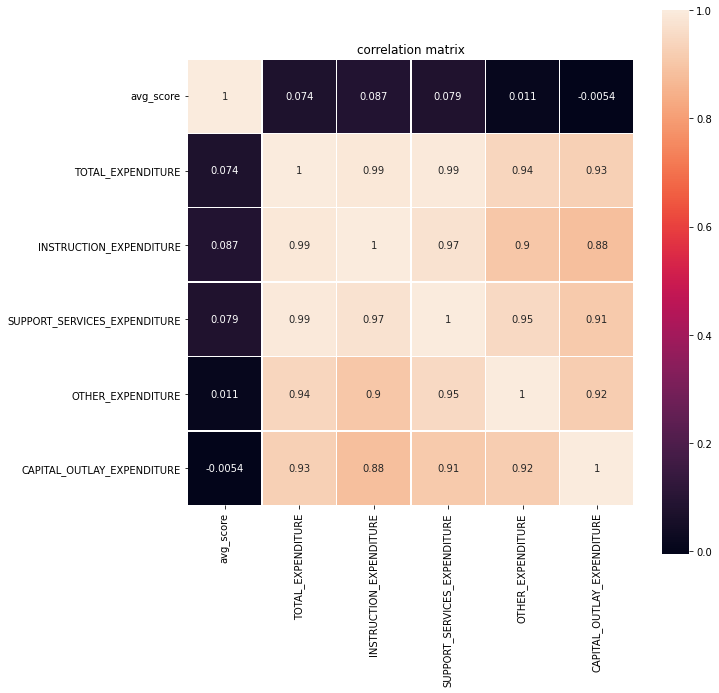

In [ ]:
corrmat_ed = ed[["avg_score","TOTAL_EXPENDITURE","INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()
plt.figure(figsize=(10,10))

sns.heatmap(corrmat_ed, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

It seems that Instruction is the highest correlated expenditure with avg score.

3. Now, apply PCA to the four expenditure types. How much of the total variance is explained by the first component?


In [ ]:
X = StandardScaler().fit_transform(ed[["TOTAL_EXPENDITURE","INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]])

# The NumPy covariance function assumes that variables are represented by rows,
# not columns. So transpose `X`.
Xt = X.T
Cx = np.cov(Xt)

In [ ]:
# Calculating eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The proportion of total variance in the dataset explained by each',
    'component calculated by hand\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.45611663 -0.44670541 -0.45409337 -0.44311725 -0.43572721]
Eigenvalue 1: 4.7698468319455465
----------------------------------------
Eigenvector 2: 
[-0.24352957 -0.52780417 -0.23633055  0.33271147  0.70396524]
Eigenvalue 2: 0.1447012404631401
----------------------------------------
Eigenvector 3: 
[ 0.10311413  0.27137464 -0.15059643 -0.76751698  0.55132719]
Eigenvalue 3: 0.08169693181396159
----------------------------------------
Eigenvector 4: 
[-0.84936106  0.40881984  0.31603459  0.04013105  0.09981864]
Eigenvalue 4: 0.0005009330406010525
----------------------------------------
Eigenvector 5: 
[ 0.02458109 -0.53018786  0.78446793 -0.31977705  0.02548149]
Eigenvalue 5: 0.014006750908798585
----------------------------------------
The proportion of total variance in the dataset explained by each component calculated by hand
 [9.51922222e-01 2.88781446e-02 1.63043233e-02 9.99716154e-05
 2.79533870e-03]


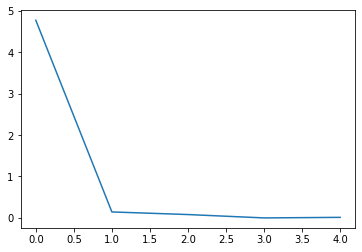

[4.76984683e+00 1.44701240e-01 8.16969318e-02 5.00933041e-04
 1.40067509e-02]


In [ ]:
# Print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [ ]:
X = ed[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
                  "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
ed["pca_1"] = sklearn_pca.fit_transform(X)

The first component can explain around 95% of the variance.

4. What is the correlation between the overall score variable and the first principal component?


In [ ]:
ed[['pca_1','avg_score']].corr()

,pca_1,avg_score
pca_1,1.000000,0.044596
avg_score,0.044596,1.000000


It says that the correlation between the two is around 0.045

5. If you were to choose the best variables for your model, would you prefer using the first principal component instead of the expenditure variables? Why?

The first principal component has a much lower correlation than support, instruction, and total expenditure when looking at average score. It would be better to use any of those three, specifically instruction which has the highest correlation. This PCA didn't work well because all of the expenditures, as we saw above, are highly correlated with eachother.

In [ ]:
ed2[["GRADES_4_G","GRADES_8_G"]].sum()[0]-ed2[["GRADES_4_G","GRADES_8_G"]].sum()[1]

364571.0